In this script I use the Amazon Featured Offer Demand system as the environment. We obtained this demand system using the high-frequency and large-scale data collected from the top 5000 best seller ASINs in the "Books" section from Amazon (by Nov. 2024). We assume that the Demand system is still in logit form, but the winner of the Buy Box can obtain an additional utility in the demand that makes it significantly larger compared with other counterparts. 

The Amazon Buy Box assignment system is built upon predictions from absorbed results.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar
from env.AmazonLogitDemandPricing_env import AmazonLogitDemandPricingEnv
from rf_interface import load_pipeline, predict
from joblib import Parallel, delayed
np.random.seed(42)
import os
FIGURE_DIR = "./figure"
DATA_DIR = "./data"

In [70]:
# Load the pipeline
rf_model = load_pipeline()
FEATURE_NAMES = list(rf_model.feature_names_in_)
print("Feature names:", FEATURE_NAMES)

Loaded pipeline from 'pipe_red_rf.joblib'
Feature names: ['isAmazon', 'isFBA', 'avg_price_rank_60d', 'avg_price_rank_14d', 'avg_price_rank_30d', 'avg_self_price_30d', 'avg_self_price_14d', 'price_rank', 'avg_self_price_60d', 'price_diff']


In [71]:
class DQNAgent:
    def __init__(self, n_price, lr=1e-2, gamma=0.9, hidden_dim=32):
        # state = [p_idx1, p_idx2, is_bb]  
        self.state_dim = 3
        self.n_actions = n_price
        self.gamma = gamma

        self.net = nn.Sequential(
            nn.Linear(self.state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.n_actions)
        )
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.omega = 1.5e-5
        self.t = 0

    def take_action(self, state): # state = [p_idx1, p_idx2, is_bb]
        epsilon = np.exp(-self.t * self.omega)
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        with torch.no_grad():
            q = self.net(torch.FloatTensor(state))
            return int(torch.argmax(q).item())

    def update(self, states, actions, rewards, next_states, dones):
        """
        All inputs are sequences / NumPy arrays of equal length B.
        """
        states      = torch.as_tensor(states,      dtype=torch.float32)   # (B, 3)
        next_states = torch.as_tensor(next_states, dtype=torch.float32)   # (B, 3)
        actions     = torch.as_tensor(actions,     dtype=torch.long).unsqueeze(1)   # (B, 1)
        rewards     = torch.as_tensor(rewards,     dtype=torch.float32).unsqueeze(1)# (B, 1)
        dones       = torch.as_tensor(dones,       dtype=torch.float32).unsqueeze(1)# (B, 1)

        q_values = self.net(states).gather(1, actions)                    # (B, 1)
        next_q   = self.net(next_states).max(1, keepdim=True)[0]          # (B, 1)
        target   = rewards + self.gamma * next_q * (1 - dones)

        loss = self.criterion(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.t += 1


In [72]:
def joint_to_index(i, j, grid_size):
    """Convert joint action (i,j) to index in Q-table."""
    return i * grid_size + j


class QLearningRuleAgent:
    """
    Q-learning agent for the duopoly‐logit pricing game.
    Instead of using a Q-table to pick price index, this agent uses a Q-table to pick one of the following rules:
        - Rule 0: pick the price that matches the price index played by the other player in the previous round.
        - Rule 1: pick the price that is one index higher than the price index played by the other player in the previous round. (if the index is greater than n_actions-1, just pick n_actions-1)
        - Rule 2: pick the price that is one index lower than the price index played by the other player in the previous round. (if the index is less than or equal to 0, just pick 0)
        - Rule 3: Do nothing and keep the price index played in the previous round.
    Specific restriction: The RuleAgent can only pick one of the four rules, once picked, the agent will keep using the same rule for 4 rounds before next action change.
      - State s_t = price index played in previous round by the two players (i,j).
      - Action a_t ∈ {0,1,2,3} picks the next rule.
      - Greedy policy: always pick argmax_a Q[s, a].
    """
    def __init__(self, n_actions, alpha=0.1, gamma=0.9, cost=2.0, prices=None,):
        self.n_price_actions = n_actions      # e.g. 25 price levels
        self.n_rules = 4                      # exactly 4 rules
        self.alpha = alpha
        self.gamma = gamma
        self.omega = 1.5e-5
        self.t = 0                            # global time step for ε
        # Q-table: rows = joint‐state index, cols = rule‐index (0…3)
        self.Q = np.random.uniform(10, 20, size=(n_actions**2, self.n_rules))
        # bookkeeping for “stick with same rule for 4 periods”
        self.current_rule = 0
        self.rule_timer = 4   # so we pick fresh immediately on t=0
        # track last price index
        self.last_price_idx = None

    def take_action(self, state, rival_pre_price_idx, own_pre_price_idx):
        # state encodes (own_pre, rival_pre); so we could also unpack it
        # but we pass in rival_pre and own_pre explicitly.
        # if self.rule_timer >= 4:
        if self.rule_timer >= 4:
            epsilon = np.exp(-self.t * self.omega)
            if np.random.rand() < epsilon:
                new_rule = np.random.randint(self.n_rules)
            else:
                new_rule = int(np.argmax(self.Q[state]))
            self.current_rule = new_rule
            self.rule_timer = 0
        price_idx = self._apply_rule(self.current_rule,
                                     rival_pre_price_idx,
                                     own_pre_price_idx)
        self.rule_timer += 1
        return price_idx

    def _apply_rule(self, rule, rival_idx, own_idx):
        if rule == 0:
            return rival_idx
        elif rule == 1:
            return min(rival_idx + 1, self.n_price_actions - 1)
        elif rule == 2:
            return max(rival_idx - 1, 0)
        elif rule == 3:
            # hold your own last price
            return own_idx

    def update(self, state, rule, reward, next_state):
        best_next = np.max(self.Q[next_state])
        td_target = reward + self.gamma * best_next
        self.Q[state, rule] += self.alpha * (td_target - self.Q[state, rule])
        self.t += 1

In [73]:
# Replay Buffer
Transition = namedtuple('Transition', 
                        ('state','action','reward','next_state','done'))
class ReplayBuffer:
    def __init__(self, capacity=10_000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size=64):
        idx = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in idx]
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

In [74]:
# Compute features for RF model
def compute_features(price_hist, t):
    """
    price_hist: deque of past prices (floats), length >= 60
    t: current time index
    returns feature vector for RF model for this seller
    """
    arr = np.array(price_hist)
    # ranks: 1=lowest price. use argsort
    ranks = arr.argsort().argsort() + 1  
    feats = [
        0, 
        1,
        np.mean(ranks[-60:]),
        np.mean(ranks[-14:]),
        np.mean(ranks[-30:]),
        np.mean(arr[-30:]),
        np.mean(arr[-14:]),
        ranks[-1],
        np.mean(arr[-60:]),
        arr[-1] - np.min(arr[-1])  # since only one price, price_diff = 0
    ]
    return feats

In [ ]:
# Single Simulation

def simulate_DQNpQr(env, periods=10_000, alpha=0.1, gamma=0.9):
    # agents
    agent_0 = DQNAgent(n_price=len(env.prices))
    agent_1 = QLearningRuleAgent(n_actions=len(env.prices), alpha=alpha, gamma=gamma, prices=env.prices, cost=env.cost)
    buffer = ReplayBuffer()
    # history trackers
    hist0, hist1 = [], []
    # price deques
    dq0 = deque(maxlen=60)
    dq1 = deque(maxlen=60)
    # init
    (obs_0, obs_1), info = env.reset()
    # p0, p1 = obs_0, obs_1 # obs are prices.
    is_bb0 = is_bb1 = 0
    state0 = [obs_0, obs_1, is_bb0]
    # print('Check', obs_0, obs_1, len(env.prices))
    state1 = joint_to_index(obs_0, obs_1, len(env.prices))

    dq0.append(env.prices[obs_0]); dq1.append(env.prices[obs_1])

    for t in range(periods):
# TODO: Start from here.
        state0 = [obs_0, obs_1, is_bb0]
        state1 = joint_to_index(obs_0, obs_1, len(env.prices)) # returns a tuple (i,j) where i,j are state indices for the Q-table
        # actions
        a0 = agent_0.take_action(state0)
        a1_price_idx = agent_1.take_action(state1, obs_1, obs_0)
        # RF features & predict buy-box
        feats0 = compute_features(dq0, t)
        feats1 = compute_features(dq1, t)
        df0 = pd.DataFrame([feats0], columns=FEATURE_NAMES)
        df1 = pd.DataFrame([feats1], columns=FEATURE_NAMES)
        probs0 = rf_model.predict_proba(df0)[:,1][0]
        probs1 = rf_model.predict_proba(df1)[:,1][0]
        # ensure one winner. Winner with higher prob wins
        is_bb0 = int(probs0 >= probs1)
        is_bb1 = int(probs1 > probs0)
        # env step
        (_ , _), (r0, r1), done, _, _ = env.step((a0, a1_price_idx), (is_bb0, is_bb1))
        # store
        hist0.append(env.prices[a0]); hist1.append(env.prices[a1_price_idx])
        # replay buffer
        next_state0 = [a0, a1_price_idx, is_bb0]
        buffer.push(state0, a0, r0, next_state0, done)
        # learn
        if len(buffer) > 200:
            batch = buffer.sample(32)
            agent_0.update(batch.state, batch.action, batch.reward, batch.next_state, batch.done)
        # learn rule agent
        next_state1 = joint_to_index(a0, a1_price_idx, len(env.prices))
        agent_1.update(state1, agent_1.current_rule, r1, next_state1)
        # advance
        obs_0, obs_1 = a0, a1_price_idx
        dq0.append(env.prices[a0]); dq1.append(env.prices[a1_price_idx])
        if done: break

    return np.array(hist0), np.array(hist1)

def simulate_QrQr(env, periods=10_000):
    # maybe we should consider buy box in the state. But now I ignore that for simplicity.
    # agents
    agent_0 = QLearningRuleAgent(n_actions=len(env.prices), alpha=0.1, gamma=0.9, prices=env.prices, cost=env.cost)
    agent_1 = QLearningRuleAgent(n_actions=len(env.prices), alpha=0.1, gamma=0.9, prices=env.prices, cost=env.cost)
    # history trackers
    hist0, hist1 = [], []
    # init
    (obs_0, obs_1), info = env.reset()
    state = joint_to_index(obs_0, obs_1, len(env.prices)) # returns a tuple (i,j) where i,j are state indices for the Q-table
        # price deques
    dq0 = deque(maxlen=60)
    dq1 = deque(maxlen=60)

    dq0.append(env.prices[obs_0]); dq1.append(env.prices[obs_1])
    # p0, p1 = obs_0, obs_1 # obs are prices.

    for t in range(periods):
        # actions
        a0 = agent_0.take_action(state, rival_pre_price_idx=obs_1, own_pre_price_idx=obs_0)
        a1 = agent_1.take_action(state, rival_pre_price_idx=obs_0, own_pre_price_idx=obs_1)
        # RF features & predict buy-box
        feats0 = compute_features(dq0, t)
        feats1 = compute_features(dq1, t)
        df0 = pd.DataFrame([feats0], columns=FEATURE_NAMES)
        df1 = pd.DataFrame([feats1], columns=FEATURE_NAMES)
        probs0 = rf_model.predict_proba(df0)[:,1][0]
        probs1 = rf_model.predict_proba(df1)[:,1][0]
        # ensure one winner. Winner with higher prob wins
        is_bb0 = int(probs0 >= probs1)
        is_bb1 = int(probs1 > probs0)
        # env step
        (next_obs_0 , next_obs_1), (r0, r1), done, _, _ = env.step((a0, a1), (is_bb0, is_bb1))
        # store
        hist0.append(env.prices[a0]); hist1.append(env.prices[a1])
        # learn
        next_state= joint_to_index(a0, a1, len(env.prices))
        agent_0.update(state, agent_0.current_rule, r0, next_state)
        agent_1.update(state, agent_1.current_rule, r1, next_state)
        # advance
        obs_0, obs_1 = next_obs_0, next_obs_1
        dq0.append(env.prices[a0]); dq1.append(env.prices[a1])
        if done: break

    return np.array(hist0), np.array(hist1)

In [ ]:
# Simulation: DQN vs Rule

runs, periods = 10, 200_000
# runs, periods = 1, 800

def one_run(_):
    env = AmazonLogitDemandPricingEnv(grid_size=25)
    h0, h1 = simulate_DQNpQr(env, periods=periods)
    return h0, h1
# Parallelize the simulation
results = Parallel(n_jobs=os.cpu_count() - 1)(delayed(one_run)(i) for i in range(runs))
all0 = np.vstack([res[0] for res in results])  # shape (runs, periods)
all1 = np.vstack([res[1] for res in results])  # shape (runs, periods)

avg0 = all0.mean(axis=0)
avg1 = all1.mean(axis=0)

env = AmazonLogitDemandPricingEnv(grid_size=25)



Check 9 5 25


In [ ]:
# Save the runs in to csv file. Only save the prices
df0 = pd.DataFrame(all0, columns=[f"price_{i}" for i in range(all0.shape[1])])
df1 = pd.DataFrame(all1, columns=[f"price_{i}" for i in range(all1.shape[1])])
df0.to_csv(os.path.join(DATA_DIR, f"dqn_vs_rule_dqn_prices_{runs}_{periods}.csv"), index=False)
df1.to_csv(os.path.join(DATA_DIR, f"dqn_vs_rule_rule_prices_{runs}_{periods}.csv"), index=False)

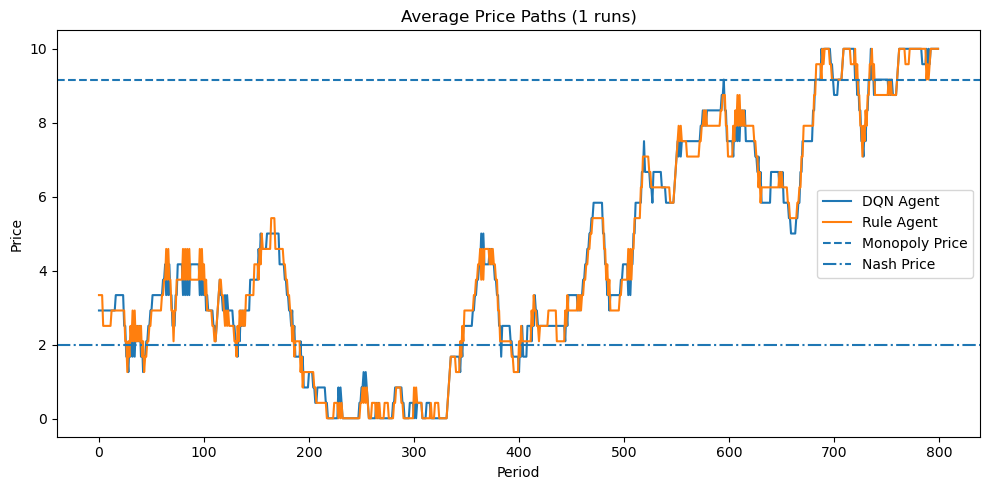

In [88]:
# Visualize: DQN vs Rule
import scipy.optimize as so

# monopoly
mono = so.minimize_scalar(
    lambda p: -(p-env.cost)*(np.exp((env.a_12-p)/env.mu)
    /(np.exp((env.a_12-p)/env.mu)+np.exp(env.a_0/env.mu))),
    bounds=(env.prices[0], env.prices[-1]), method='bounded'
).x

# nash
def eqs(x):
    pi, pj = x
    d_i = np.exp((env.a_12-pi)/env.mu)/(np.exp((env.a_12-pi)/env.mu)
         +np.exp((env.a_12-pj)/env.mu)+np.exp(env.a_0/env.mu))
    d_j = np.exp((env.a_12-pj)/env.mu)/(np.exp((env.a_12-pi)/env.mu)
         +np.exp((env.a_12-pj)/env.mu)+np.exp(env.a_0/env.mu))
    return [(pi-env.cost)*d_i, (pj-env.cost)*d_j]
ne = so.fsolve(eqs, (env.prices[0], env.prices[0]))[0]

# %% [markdown]
# ## 10. Plot Results

# %%
plt.figure(figsize=(10,5))
plt.plot(avg0, label='DQN Agent')
plt.plot(avg1, label='Rule Agent')
plt.axhline(mono, linestyle='--', label='Monopoly Price')
plt.axhline(ne, linestyle='-.', label='Nash Price')
plt.xlabel('Period')
plt.ylabel('Price')
plt.title(f'Average Price Paths ({runs} runs)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, f"amz_dqn_avg_price_paths_{runs}_{periods}.png"), dpi=300)
plt.show()

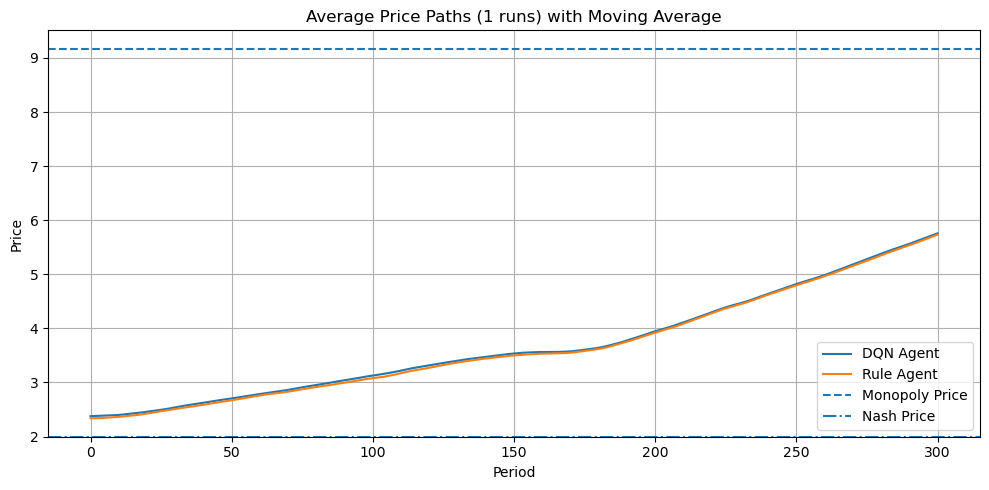

In [89]:
# Instead, plot with moving average
def move_average(x, window):
    """Compute moving average of x with window size."""
    return np.convolve(x, np.ones(window), 'valid') / window

window = 500
avg0_ma = move_average(avg0, window)
avg1_ma = move_average(avg1, window)
plt.figure(figsize=(10,5))
plt.plot(avg0_ma, label='DQN Agent')
plt.plot(avg1_ma, label='Rule Agent')
plt.axhline(mono, linestyle='--', label='Monopoly Price')
plt.axhline(ne, linestyle='-.', label='Nash Price')
plt.xlabel('Period')
plt.ylabel('Price')
plt.title(f'Average Price Paths ({runs} runs) with Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, f"amz_dqn_avg_price_paths_ma_{runs}_{periods}.png"), dpi=300)
plt.show()

In [ ]:
# Simulation: Rule vs Rule
runs, periods = 10, 200_000
# runs, periods = 1, 800
def one_run_rule(_):
    env = AmazonLogitDemandPricingEnv(grid_size=25)
    h0, h1 = simulate_QrQr(env, periods=periods)
    return h0, h1
# Parallelize the simulation
results = Parallel(n_jobs=os.cpu_count() - 1)(delayed(one_run_rule)(i) for i in range(runs))
all0 = np.vstack([res[0] for res in results])  # shape (runs, periods)
all1 = np.vstack([res[1] for res in results])  # shape (runs, periods)
avg0 = all0.mean(axis=0)
avg1 = all1.mean(axis=0)
# Save the runs in to csv file. Only save the prices
df0 = pd.DataFrame(all0, columns=[f"price_{i}" for i in range(all0.shape[1])])
df1 = pd.DataFrame(all1, columns=[f"price_{i}" for i in range(all1.shape[1])])
df0.to_csv(os.path.join(DATA_DIR, f"rule_rule_prices_1_{runs}_{periods}.csv"), index=False)
df1.to_csv(os.path.join(DATA_DIR, f"rule_rule_prices_2_{runs}_{periods}.csv"), index=False)

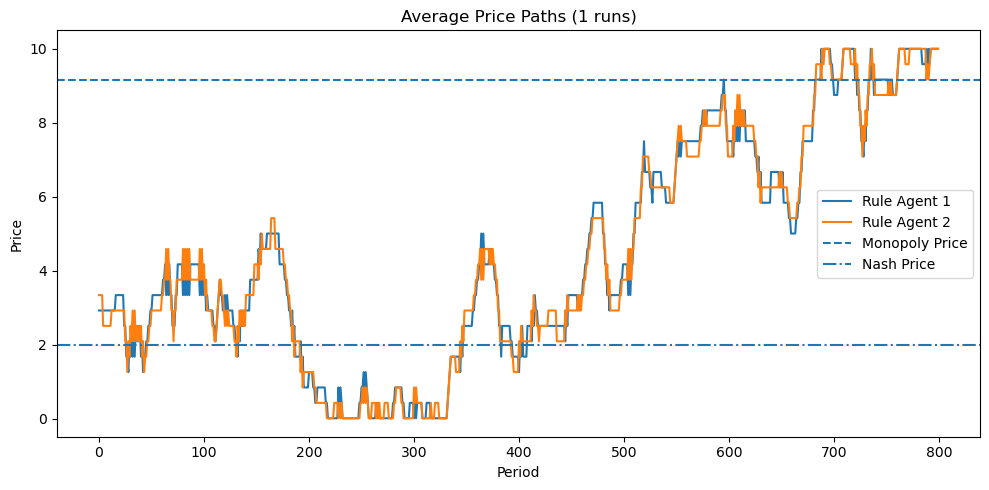

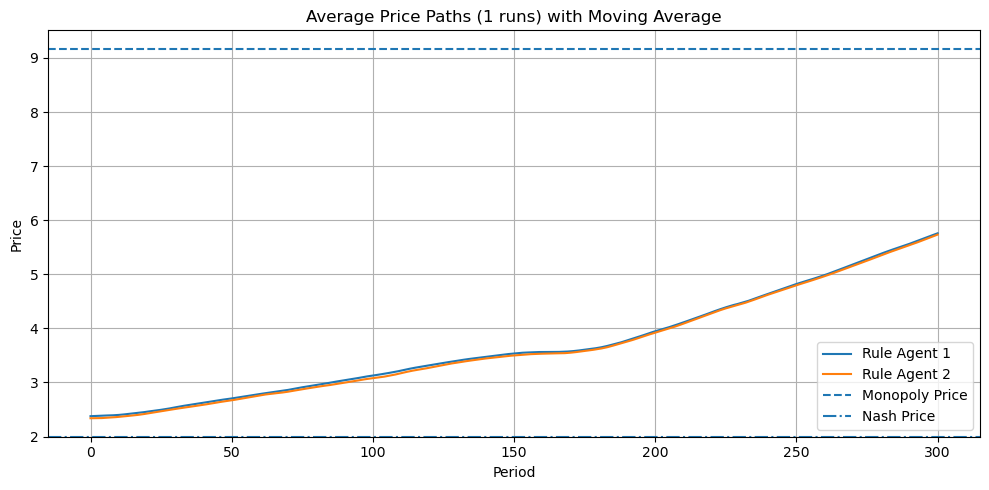

In [90]:
# Visualize: Rule vs Rule
plt.figure(figsize=(10,5))
plt.plot(avg0, label='Rule Agent 1')
plt.plot(avg1, label='Rule Agent 2')
plt.axhline(mono, linestyle='--', label='Monopoly Price')
plt.axhline(ne, linestyle='-.', label='Nash Price')
plt.xlabel('Period')
plt.ylabel('Price')
plt.title(f'Average Price Paths ({runs} runs)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "amz_rule_avg_price_paths.png"), dpi=300)
plt.show()
# Instead, plot with moving average
avg0_ma = move_average(avg0, window)
avg1_ma = move_average(avg1, window)
plt.figure(figsize=(10,5))
plt.plot(avg0_ma, label='Rule Agent 1')
plt.plot(avg1_ma, label='Rule Agent 2')
plt.axhline(mono, linestyle='--', label='Monopoly Price')
plt.axhline(ne, linestyle='-.', label='Nash Price')
plt.xlabel('Period')
plt.ylabel('Price')
plt.title(f'Average Price Paths ({runs} runs) with Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, f"amz_rule_avg_price_paths_ma_{runs}_{periods}.png"), dpi=300)
plt.show()